In [3]:
'''
Deep Learning
Assignment 1

The objective of this assignment is to learn about simple data curation practices, 
and familiarize you with some of the data we'll be reusing later.

This notebook uses the notMNIST dataset to be used with python experiments. 
This dataset is designed to look like the classic MNIST dataset, while looking
a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.
'''

"\nDeep Learning\nAssignment 1\n\nThe objective of this assignment is to learn about simple data curation practices, \nand familiarize you with some of the data we'll be reusing later.\n\nThis notebook uses the notMNIST dataset to be used with python experiments. \nThis dataset is designed to look like the classic MNIST dataset, while looking\na little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.\n"

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline



In [5]:
'''First, we'll download the dataset to our local machine. The data consists of characters 
rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J'
(10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, 
it should be possible to train models quickly on any machine.'''

"First, we'll download the dataset to our local machine. The data consists of characters \nrendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J'\n(10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, \nit should be possible to train models quickly on any machine."

In [6]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)


Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


In [7]:
'''Extract the dataset from the compressed .tar.gz file. This should give you a set of directories, labeled A through J.'''

'Extract the dataset from the compressed .tar.gz file. This should give you a set of directories, labeled A through J.'

In [8]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)


Extracting data for ./notMNIST_large. This may take a while. Please wait.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
Extracting data for ./notMNIST_small. This may take a while. Please wait.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


In [ ]:
'''Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we
just downloaded. Hint: you can use the package IPython.display'''

./notMNIST_small/F/QWRhbXMgVGhpbiBJdGFsaWMudHRm.png


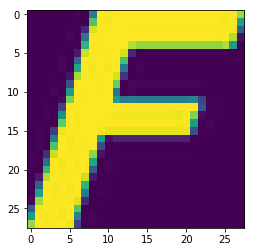

./notMNIST_small/B/QXBvbGxvLVNlbWlCb2xkLm90Zg==.png


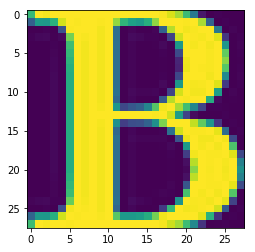

./notMNIST_small/H/QXJpc3RvY3JhdFN0ZC5vdGY=.png


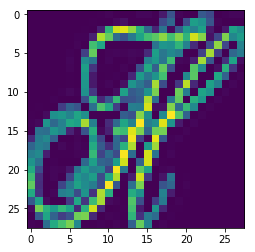

In [3]:
from numpy import random


path_large='./notMNIST_large/'
path_small='./notMNIST_small/'

imgFiles_large = os.listdir(path_large)
imgFiles_small = os.listdir(path_small)


#iterate through small images
for i in range(0,3):
    random_index_path = random.randint(0,len(imgFiles_small))        
    
    temp_path = path_small + imgFiles_small[random_index_path] #path to random directory
    temp_list_img = os.listdir(temp_path) #list all images of files within random directory    
       
    radom_index_img = random.randint(0,len(temp_list_img))
    
    #pick some random image
    final_path_image = temp_path +'/'+ temp_list_img[radom_index_img]
       
    print(final_path_image) #print final path  
        

    image = mpimg.imread(final_path_image) #image from path
    image_plot = plt.imshow(image)
    plt.show()
    


